# Aligning single-cell resolution breast cancer spatial transcriptomics data to corresponding H&E staining image from Xenium

In this notebook, we take a single cell resolution spatial transcriptomics datasets of a breast cancer section profiled by the Xenium technology and align it to a corresponding H&E staining image of the same tissue section. See the bioRxiv preprint for more details about this data: https://www.biorxiv.org/content/10.1101/2022.10.06.510405v2 

According to the authors, "Due to the non-destructive nature of the Xenium workflow, we were able to perform H&E staining...on the same section post-processing." However, as the H&E staining and imaging was done seprately to the spatial transcriptomics data collection, alignment is still needed to register the H&E staining image with the single cell positions from the spatial transcriptomics data. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
# OPTION A: import STalign after pip or pipenv install
from STalign import STalign

In [3]:
# ## OPTION B: skip cell if installed STalign with pip or pipenv
# import sys
# sys.path.append("../../STalign") 

# ## import STalign from upper directory
# import STalign

To obtain the single cell spatial transcriptomics data, we can download the `Xenium Output Bundle` from the 10X website: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast Expanding the downloaded `Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip`, we will use the single cell positions stored in `cells.csv.gz`. Likewise, we can download the accompanying H&E staining image `Supplemental: Post-Xenium H&E image (TIFF)` as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif`. 

To reproduce this tutorial, we have placed these files in a folder called [`xenium_data/`](https://github.com/JEFworks-Lab/STalign/tree/main/docs/xenium_data) with `cells.csv.gz` renamed as `Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz` for organizational purposes. Likewise, to minimize storage, we have resized the high resolution H&E TIF image into a smaller PNG image as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

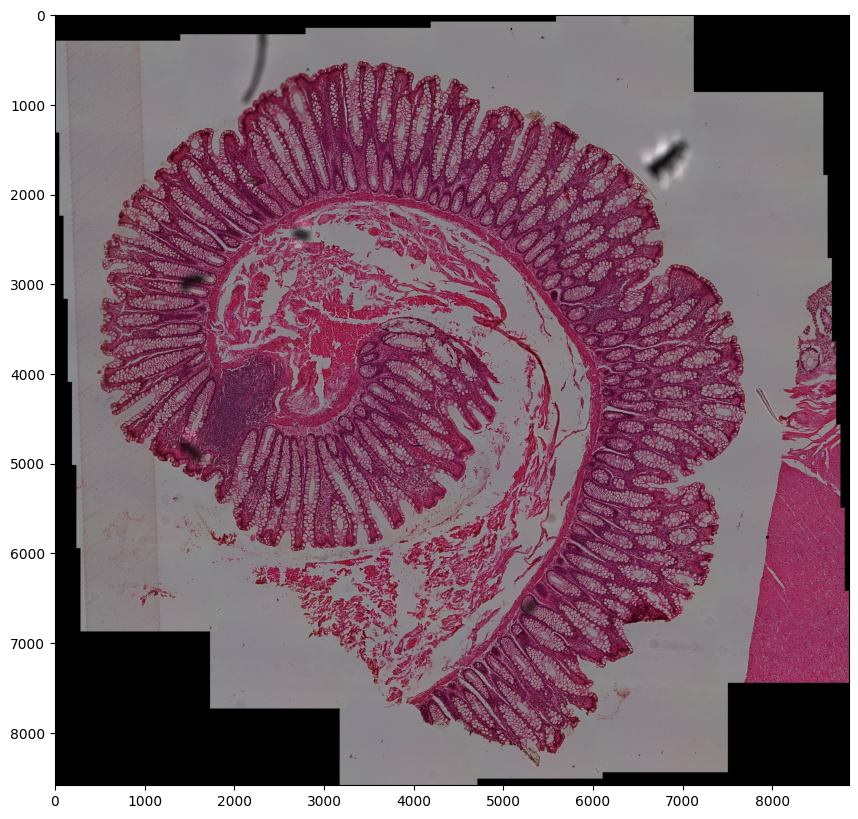

In [11]:
# Target is H&E staining image
image_file = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE.ome.tif"
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

Note that this is an RGB image that `matplotlib.pyplot` had read in as an NxMx3 matrix with values ranging from 0 to 1.

In [12]:
print(V.shape)
print(V.min())
print(V.max())

(8585, 8851, 3)
0
255


We will use `STalign` to normalize the image in case there are any outlier intensities. 

In [13]:
Inorm = STalign.normalize(V)

print(Inorm.min())
print(Inorm.max())

#fig,ax = plt.subplots()
#ax.imshow(Inorm)

0.0
1.0


We will transpose `Inorm` to be a 3xNxM matrix for downstream analyses. We will also create some variances `YI` and `XI` to keep track of the image size.

In [14]:
I = Inorm.transpose(2,0,1)
print(I.shape)

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
extentI = STalign.extent_from_x((YI,XI))

(3, 8585, 8851)


We can also now read in the corresponding single cell information using `pandas` as `pd`.

In [15]:
# Single cell data to be aligned
fname = '/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1.csv'
df = pd.read_csv(fname)
df.head()

Unnamed: 0     orig.ident  nCount_RNA  nFeature_RNA  index_safe  \
0  aaknmimg-1  SeuratProject          32            27  aaknmimg-1   
1  ajcikkkl-1  SeuratProject         165           137  ajcikkkl-1   
2  aaiognhg-1  SeuratProject          42            40  aaiognhg-1   
3  idihpaid-1  SeuratProject          73            64  idihpaid-1   
4  icfpikjg-1  SeuratProject         180           156  icfpikjg-1   

   transcripts  unique_transcripts  cell_centroid_x  cell_centroid_y  \
0           32                  27      4836.930664      1349.580566   
1          165                 137      5826.780273       412.257751   
2           42                  40      5202.537598      1858.666626   
3           73                  64      5618.327148       188.296234   
4          180                 156      7288.451172      1601.582153   

   cell_area  ...  doublet_finder  DOUBLET_FILTER  nCount_Intergenic.Region  \
0  16.553150  ...         Singlet            True                         0   
1  17.851304  ...         Singlet            True                         0   
2  14.874126  ...         Singlet            True                         0   
3  15.682601  ...         Singlet            True                         0   
4  18.148302  ...         Singlet            True                         0   

   nFeature_Intergenic.Region  PROBE_FILTER TRANSCRIPT_FILTER  \
0                           0          True              True   
1                           0          True              True   
2                           0          True              True   
3                           0          True              True   
4                           0          True              True   

   SIZE_FILTER_LARGE  predicted.id.score  predicted.id  PREDICT_SCORE_FILTER  
0               True            1.000000    Epithelium                  True  
1               True            0.954189   CD4+_Tcells                  True  
2               True            0.954461    Epithelium                  True  
3               True            0.837151    Epithelium                  True  
4               True            1.000000        Plasma                  True  

[5 rows x 25 columns]

For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

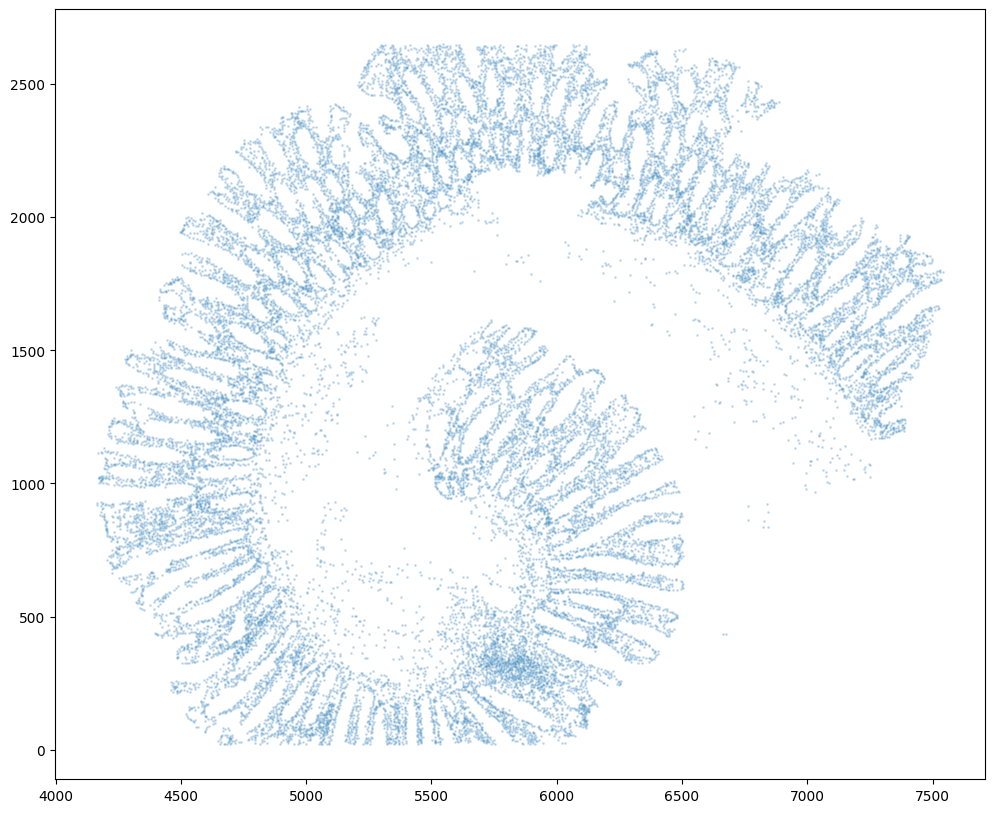

In [17]:
# get cell centroid coordinates
xM = np.array(df['cell_centroid_x'])
yM = np.array(df['cell_centroid_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xM,yM,s=1,alpha=0.2)

Note that plotting the cell centroid positions on the corresponding H&E image shows that alignment is still needed.

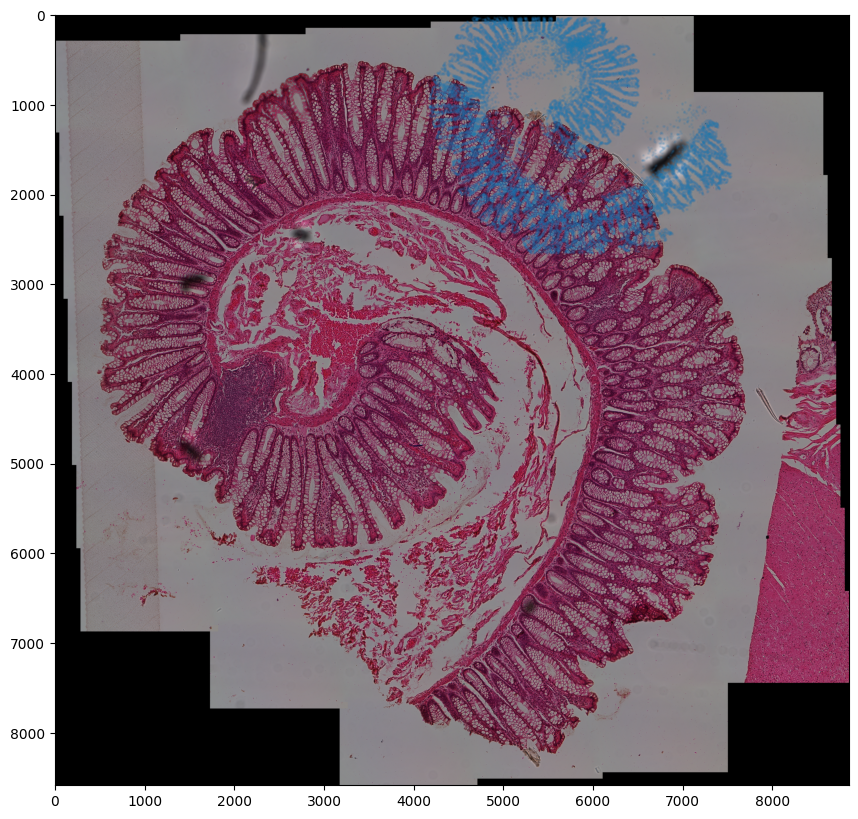

In [18]:
# plot
fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(xM,yM,s=1,alpha=0.1)

To begin our alignment, we will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 26577
10000 of 26577
20000 of 26577
26576 of 26577


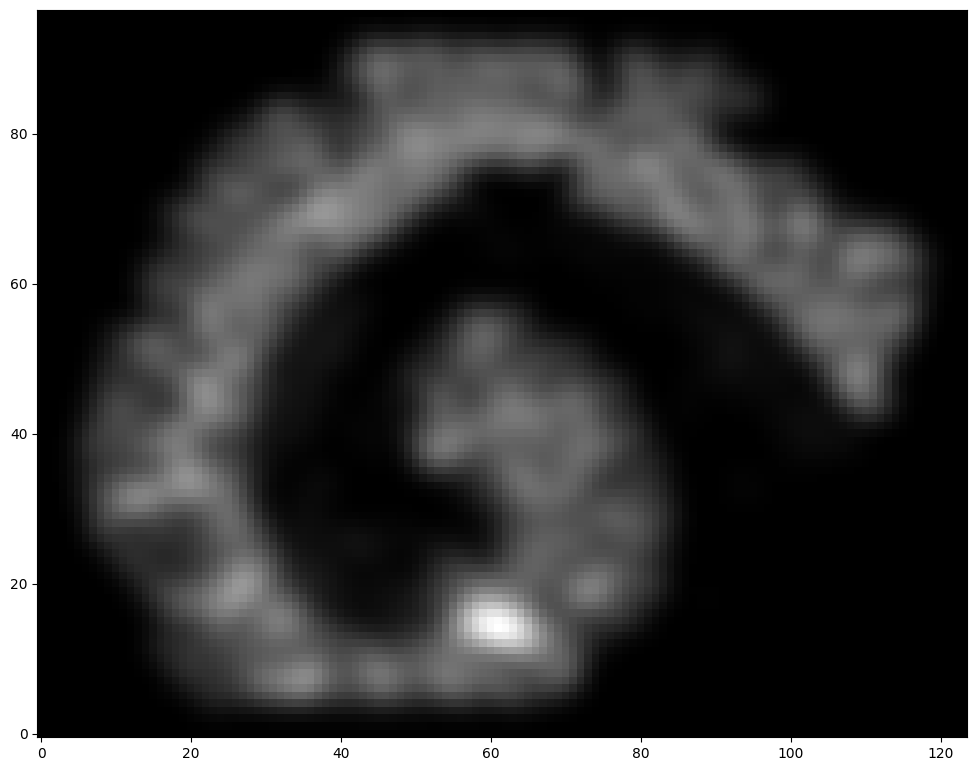

In [19]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,M,fig = STalign.rasterize(xM, yM, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1. We now have an H&E image and a rasterized image corresponding to the single cell positions from the spatial transcriptomics data that we can align.

In [20]:
print(M.shape)
J = np.vstack((M, M, M)) # make into 3xNxM
print(J.min())
print(J.max())

# normalize
J = STalign.normalize(J)
print(J.min())
print(J.max())

# double check size of things
print(I.shape)
print(M.shape)
print(J.shape)

(1, 97, 124)
0.0
14.801740981066095
0.0
1.0
(3, 8585, 8851)
(1, 97, 124)
(3, 97, 124)


`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. We manually created 3 points that visually mark similar landmarks across the two datasets that we will use to initialize a simple affine alignment from the landmark points. 

We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

In [17]:
# write out npz files for landmark point picker
np.savez('/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A', x=XI,y=YI,I=I)
np.savez('/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B', x=XJ,y=YJ,I=J)

In [22]:
%%bash
python /project/simmons_hts/kxu/.local/lib/python3.11/site-packages/STalign/point_annotator.py /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A.npz /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B.npz 

hello world
Namespace(filename=['/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A.npz', '/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B.npz'], output=[])
source image contains 
['x', 'y', 'I']
target image contains 
['x', 'y', 'I']
source output name /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A_points.npy
target output name /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B_points.npy
Figure(1200x800)
could not load previous
could not load previous


Traceback (most recent call last):
  File "/project/simmons_hts/kxu/.local/lib/python3.11/site-packages/STalign/point_annotator.py", line 157, in <module>
    name = input(f'Enter name for landmark structure {count} (or leave blank and hit enter to save): ')
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
EOFError: EOF when reading a line


Enter name for landmark structure 0 (or leave blank and hit enter to save): 

CalledProcessError: Command 'b'python /project/simmons_hts/kxu/.local/lib/python3.11/site-packages/STalign/point_annotator.py /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A.npz /project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B.npz \n'' returned non-zero exit status 1.

In [21]:
# read from file
pointsIlist = np.load('/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_A_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('/project/simmons_hts/kxu/hest/xenium_labelled/stalign/XeniumPR1S1ROI1_B_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'1': [(3988.1603225806452, 7652.524838709678)], '2': [(3370.49376344086, 3506.8306451612916)], '3': [(6668.205053763442, 2931.039784946237)]}
{'1': [(7310.689794921875, 1192.3543542861944)], '2': [(5524.289794921875, 985.5543542861947)], '3': [(5141.489794921876, 2397.9543542861943)]}


In [22]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])

pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

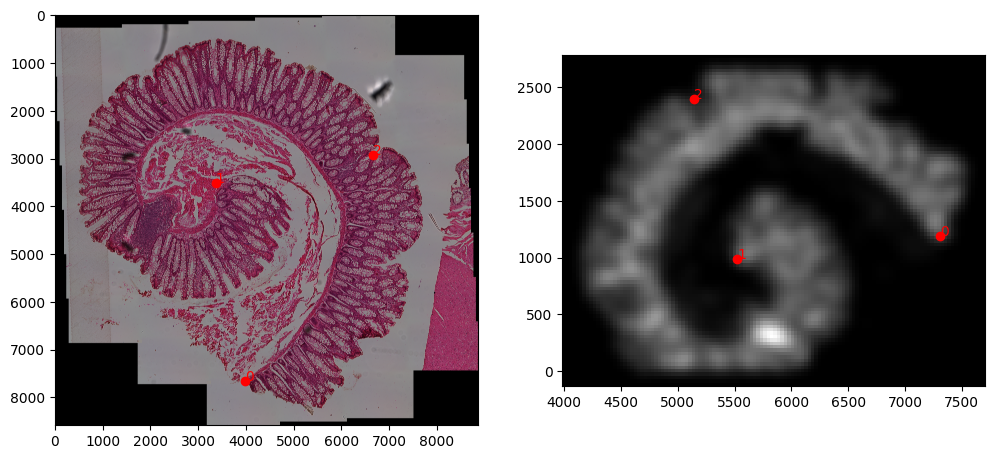

In [23]:
# plot
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red')
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')

# invert only rasterized image
ax[1].invert_yaxis()

In [24]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)

From this simple affine transformation based on landmark points, we can already apply the resulting lineared linear transformation (L) and translation (T) to align the single-cell spatial transcriptomics dataset to the H&E staining image. Note that the derived affine transformation is the transformation and translation needed to align the H&E staining image to the single-cell positions. To align the single-cell positions, we will need to invert the linear transformation matrix using `linalg.inv` and shift in the negative direction by subtracting instead of adding. 

[[-0.01357569  0.42592669]
 [ 0.43683584 -0.03980758]]
[-402.42122831 4126.55168743]
(2, 2)
(2,)
(2, 26577)


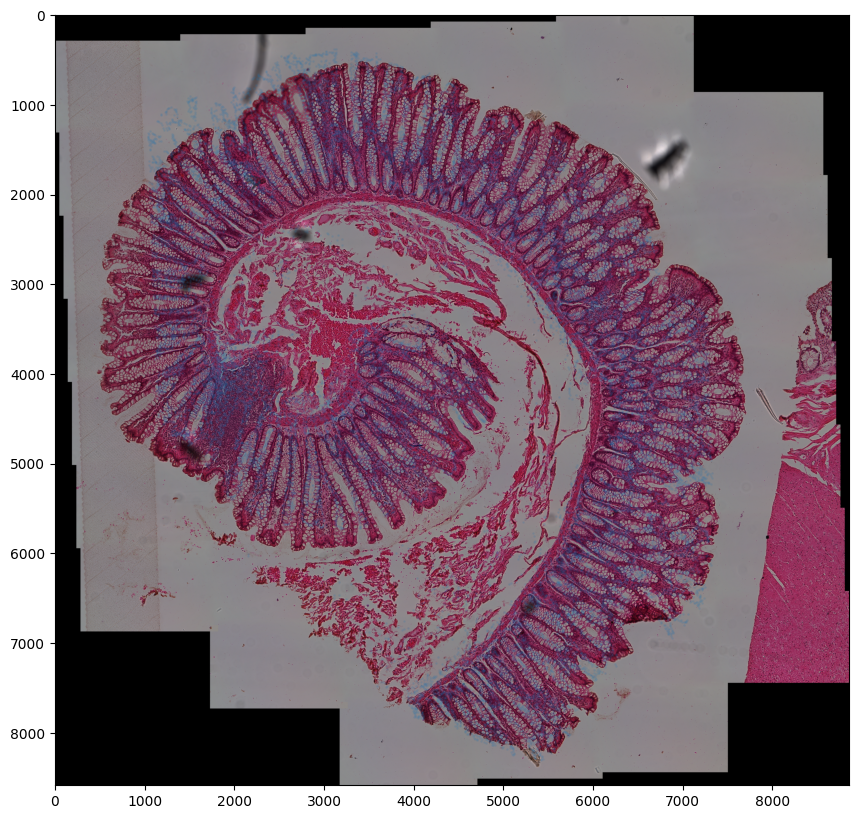

In [25]:
print(L)
print(T)
print(L.shape)
print(T.shape)

# note points are as y,x
affine = np.dot(np.linalg.inv(L), [yM - T[0], xM - T[1]]) 
print(affine.shape)
xMaffine = affine[0,:] 
yMaffine = affine[1,:] 

# plot
fig,ax = plt.subplots()
ax.scatter(yMaffine,xMaffine,s=1,alpha=0.1)
ax.imshow((I).transpose(1,2,0))

In this case, it seems like either due to the accuracy of our landmark points and/or distortions in the tissue sample introduced during the H&E staining, a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM. 

There are many parameters that can be tuned for performing this alignment. 

In [26]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

/package/python-cbrg/current/3.11.13/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/k/kxu/.local/lib/python3.11/site-packages/STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 1min 24s, sys: 2.75 s, total: 1min 27s
Wall time: 1min 28s


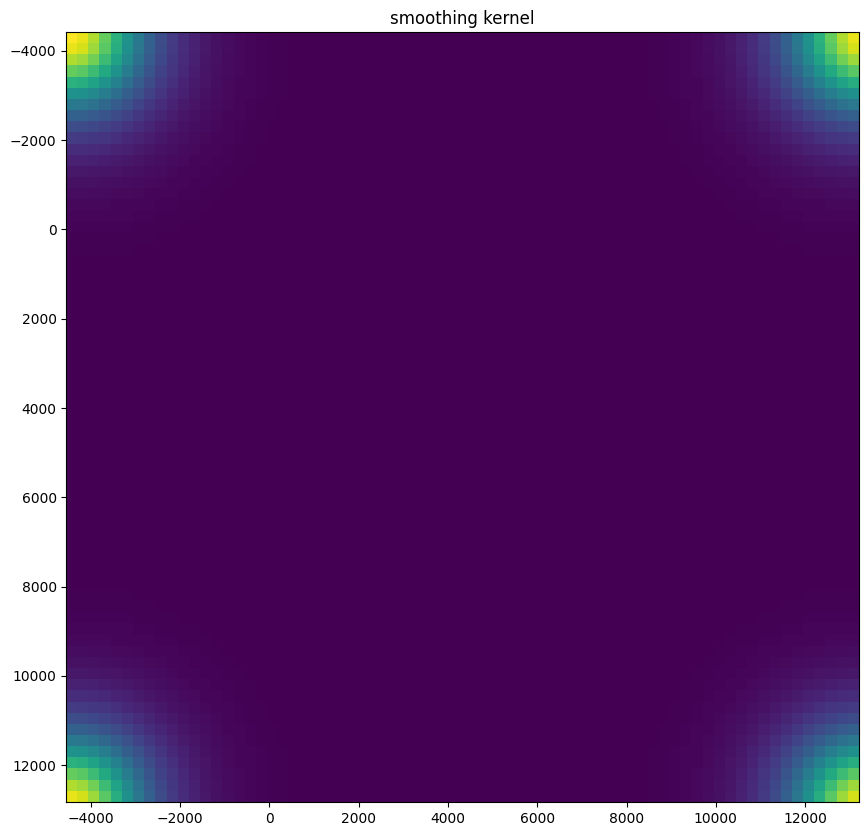

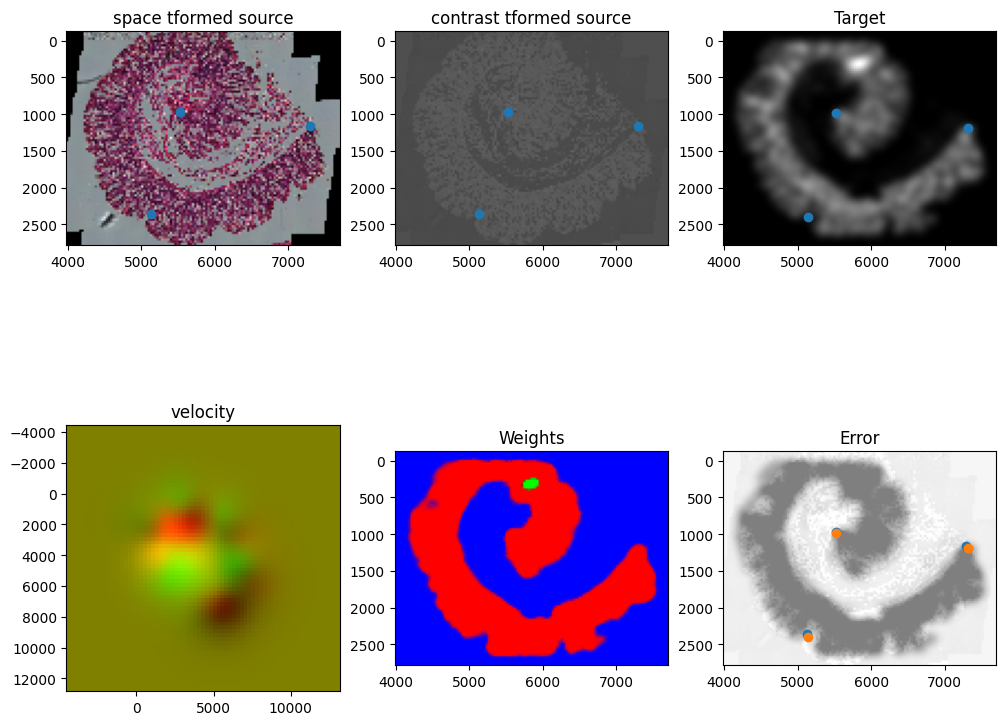

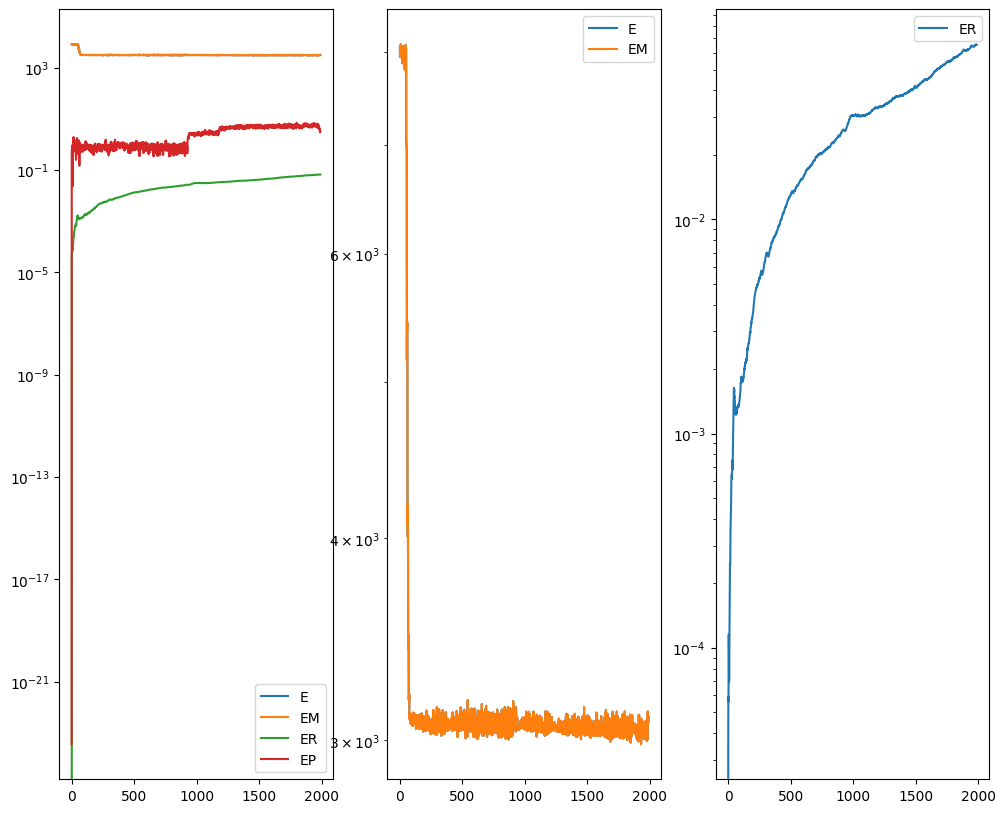

In [27]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':2000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':0.15, 
          'sigmaB':0.10,
          'sigmaA':0.11,
          'epV': 10,
          'muB': torch.tensor([0,0,0]), # black is background in target
          'muA': torch.tensor([1,1,1]) # use white as artifact 
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [28]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

In [29]:
out

{'A': tensor([[-1.5708e-02,  4.1984e-01, -3.9183e+02],
         [ 4.3495e-01, -4.2127e-02,  4.1368e+03],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
        dtype=torch.float64),
 'v': tensor([[[[-7.9892e-05,  7.1919e-05],
           [-9.5588e-05,  1.1609e-04],
           [-1.1930e-04,  1.7027e-04],
           ...,
           [-7.5822e-05, -3.4596e-05],
           [-6.9982e-05, -3.2171e-07],
           [-7.1439e-05,  3.4182e-05]],
 
          [[-9.8462e-05,  1.0788e-04],
           [-1.2380e-04,  1.6116e-04],
           [-1.5910e-04,  2.2921e-04],
           ...,
           [-7.0248e-05, -3.5376e-06],
           [-7.2322e-05,  2.8906e-05],
           [-8.1603e-05,  6.5003e-05]],
 
          [[-1.2529e-04,  1.5114e-04],
           [-1.6290e-04,  2.1790e-04],
           [-2.1337e-04,  3.0551e-04],
           ...,
           [-6.9526e-05,  2.5664e-05],
           [-7.9987e-05,  5.9021e-05],
           [-9.8211e-05,  9.9660e-05]],
 
          ...,
 
          [[-5.8

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

/package/python-cbrg/current/3.11.13/lib/python3.11/site-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


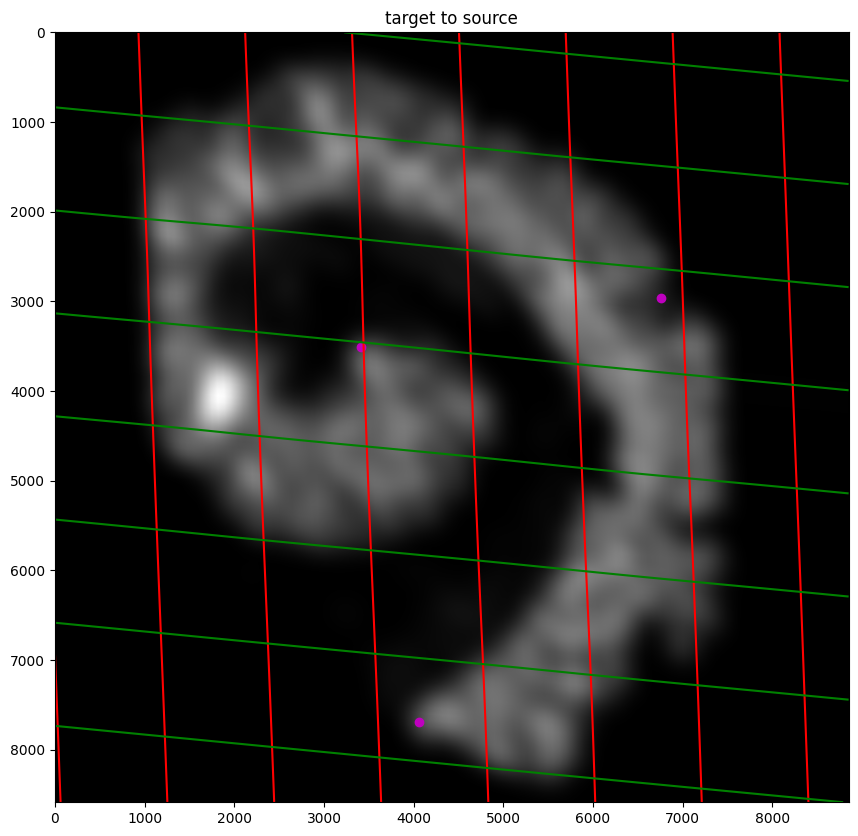

In [30]:
# now transform the points 
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = STalign.transform_points_target_to_source(xv,v,A,pointsJ)

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()
if phiipointsJ.is_cuda:
    phiipointsJ = phiipointsJ.cpu()

# plot
fig,ax = plt.subplots()

levels = np.arange(-50000,50000,500)

ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')

ax.imshow(phiiJ.permute(1,2,0),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [31]:
# Now apply to points 
tpointsJ = STalign.transform_points_target_to_source(xv,v,A,np.stack([yM, xM], -1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsJ.is_cuda:
    tpointsJ = tpointsJ.cpu()

And we can visualize the results.

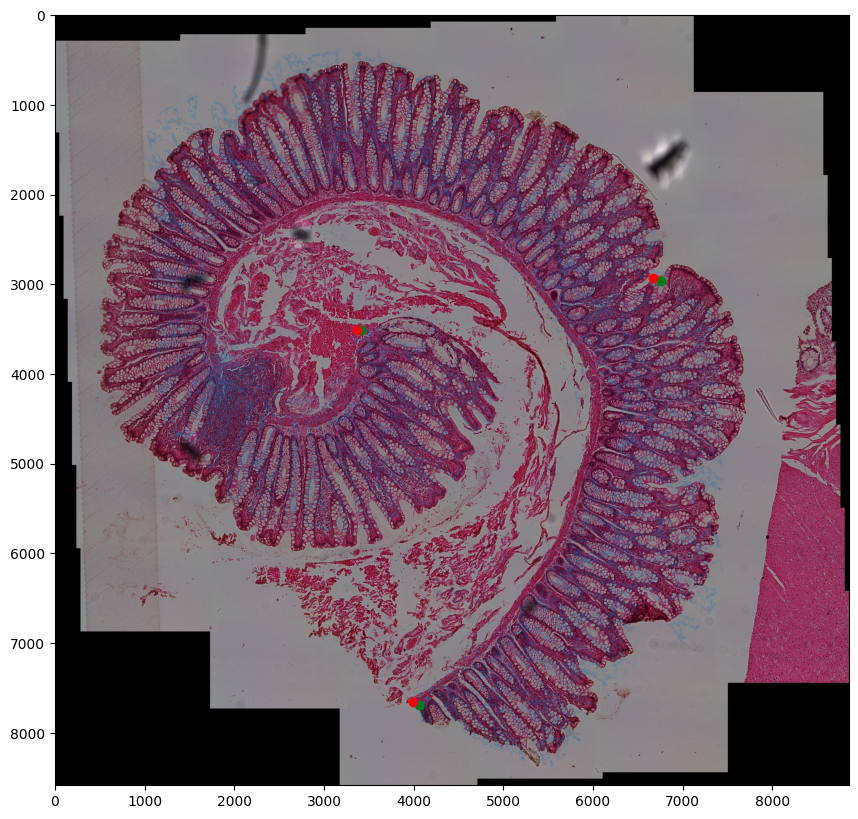

In [32]:
# plot

fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="g")
ax.scatter(pointsI[:,1],pointsI[:,0], c='r')
ax.scatter(tpointsJ[:,1].detach(),tpointsJ[:,0].detach(),s=1,alpha=0.1)

And save the new aligned positions by appending to our original data using `numpy` with `np.hstack`

In [33]:
df

Unnamed: 0     orig.ident  nCount_RNA  nFeature_RNA  index_safe  \
0      aaknmimg-1  SeuratProject          32            27  aaknmimg-1   
1      ajcikkkl-1  SeuratProject         165           137  ajcikkkl-1   
2      aaiognhg-1  SeuratProject          42            40  aaiognhg-1   
3      idihpaid-1  SeuratProject          73            64  idihpaid-1   
4      icfpikjg-1  SeuratProject         180           156  icfpikjg-1   
...           ...            ...         ...           ...         ...   
26572  hobaeeop-1  SeuratProject          79            73  hobaeeop-1   
26573  aimcdpkh-1  SeuratProject         247           210  aimcdpkh-1   
26574  iccpmhbg-1  SeuratProject         121           106  iccpmhbg-1   
26575  idmdmfhi-1  SeuratProject         102            88  idmdmfhi-1   
26576  iedjcnoi-1  SeuratProject          79            70  iedjcnoi-1   

       transcripts  unique_transcripts  cell_centroid_x  cell_centroid_y  \
0               32                  27      4836.930664      1349.580566   
1              165                 137      5826.780273       412.257751   
2               42                  40      5202.537598      1858.666626   
3               73                  64      5618.327148       188.296234   
4              180                 156      7288.451172      1601.582153   
...            ...                 ...              ...              ...   
26572           79                  73      4595.129883      1942.165894   
26573          247                 210      5773.744141       287.382477   
26574          121                 106      5937.581055      1345.784302   
26575          102                  88      4817.575684       624.769775   
26576           79                  70      4953.590332       221.479034   

       cell_area  ...  doublet_finder  DOUBLET_FILTER  \
0      16.553150  ...         Singlet            True   
1      17.851304  ...         Singlet            True   
2      14.874126  ...         Singlet            True   
3      15.682601  ...         Singlet            True   
4      18.148302  ...         Singlet            True   
...          ...  ...             ...             ...   
26572  17.053766  ...         Singlet            True   
26573  18.126590  ...         Singlet            True   
26574  16.777337  ...         Singlet            True   
26575  16.818213  ...         Singlet            True   
26576  16.465264  ...         Singlet            True   

       nCount_Intergenic.Region  nFeature_Intergenic.Region  PROBE_FILTER  \
0                             0                           0          True   
1                             0                           0          True   
2                             0                           0          True   
3                             0                           0          True   
4                             0                           0          True   
...                         ...                         ...           ...   
26572                         0                           0          True   
26573                         0                           0          True   
26574                         0                           0          True   
26575                         0                           0          True   
26576                         0                           0          True   

      TRANSCRIPT_FILTER  SIZE_FILTER_LARGE  predicted.id.score  predicted.id  \
0                  True               True            1.000000    Epithelium   
1                  True               True            0.954189   CD4+_Tcells   
2                  True               True            0.954461    Epithelium   
3                  True               True            0.837151    Epithelium   
4                  True               True            1.000000        Plasma   
...                 ...                ...                 ...           ...   
26572              True            

In [34]:
# save results by appending
results = np.hstack((df, tpointsJ.numpy()))

In [35]:
results = pd.DataFrame(
    tpointsJ.numpy(),
    columns=["cell_centroid_x_aligned", "cell_centroid_y_aligned"]
)
results = pd.concat([df, results], axis=1)
results

Unnamed: 0     orig.ident  nCount_RNA  nFeature_RNA  index_safe  \
0      aaknmimg-1  SeuratProject          32            27  aaknmimg-1   
1      ajcikkkl-1  SeuratProject         165           137  ajcikkkl-1   
2      aaiognhg-1  SeuratProject          42            40  aaiognhg-1   
3      idihpaid-1  SeuratProject          73            64  idihpaid-1   
4      icfpikjg-1  SeuratProject         180           156  icfpikjg-1   
...           ...            ...         ...           ...         ...   
26572  hobaeeop-1  SeuratProject          79            73  hobaeeop-1   
26573  aimcdpkh-1  SeuratProject         247           210  aimcdpkh-1   
26574  iccpmhbg-1  SeuratProject         121           106  iccpmhbg-1   
26575  idmdmfhi-1  SeuratProject         102            88  idmdmfhi-1   
26576  iedjcnoi-1  SeuratProject          79            70  iedjcnoi-1   

       transcripts  unique_transcripts  cell_centroid_x  cell_centroid_y  \
0               32                  27      4836.930664      1349.580566   
1              165                 137      5826.780273       412.257751   
2               42                  40      5202.537598      1858.666626   
3               73                  64      5618.327148       188.296234   
4              180                 156      7288.451172      1601.582153   
...            ...                 ...              ...              ...   
26572           79                  73      4595.129883      1942.165894   
26573          247                 210      5773.744141       287.382477   
26574          121                 106      5937.581055      1345.784302   
26575          102                  88      4817.575684       624.769775   
26576           79                  70      4953.590332       221.479034   

       cell_area  ...  nCount_Intergenic.Region  nFeature_Intergenic.Region  \
0      16.553150  ...                         0                           0   
1      17.851304  ...                         0                           0   
2      14.874126  ...                         0                           0   
3      15.682601  ...                         0                           0   
4      18.148302  ...                         0                           0   
...          ...  ...                       ...                         ...   
26572  17.053766  ...                         0                           0   
26573  18.126590  ...                         0                           0   
26574  16.777337  ...                         0                           0   
26575  16.818213  ...                         0                           0   
26576  16.465264  ...                         0                           0   

       PROBE_FILTER  TRANSCRIPT_FILTER  SIZE_FILTER_LARGE predicted.id.score  \
0              True               True               True           1.000000   
1              True               True               True           0.954189   
2              True               True               True           0.954461   
3              True               True               True           0.837151   
4              True               True               True           1.000000   
...             ...                ...                ...                ...   
26572          True               True               True           0.932386   
26573          True               True               True           0.825852   
26574          True               True               True           1.000000   
26575          True               True               True           0.829116   
26576          True               True               True           0.923428   

       predicted.id  PREDICT_SCORE_FILTER  cell_centroid_x_aligned  \
0        Epithelium                  True              2015.050625   
1       CD4+_Tcells                  True              4077.408082   
2        Epithelium                  True              2981.525084   
3        Epithe

We will finally create a compressed `.csv.gz` file  to create `Xenium_Breast_Cancer_Rep1_STalign_to_HE.csv.gz`

In [36]:
results.to_csv('/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1_STalign_to_HE.csv.gz',
               compression='gzip')
results.to_csv('/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1_STalign_to_HE.csv')

In [37]:
M_AtoB = A.numpy() if hasattr(A, "numpy") else A

# Inverse transform: B → A
M_BtoA = np.linalg.inv(M_AtoB)
M_BtoA

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# Convert tensor to numpy, then wrap in DataFrame
df_A = pd.DataFrame(A.numpy())

# Save as CSV
df_A.to_csv(
    "/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1_STalign_to_HE_matrix.csv",
    index=False, header = False
)

df_M_AtoB = pd.DataFrame(M_AtoB)
# Save as CSV
df_M_AtoB.to_csv(
    "/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1_STalign_to_HE_matrix.csv",
    index=False, header = False
)

In [ ]:
df_A